In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('PriceIndexCatFood.csv',index_col = 'Date' , parse_dates=True)
df.index.freq = 'MS'

In [3]:
df.head()

,CatFood
Date,
1985-12-01,100.0
1986-01-01,100.0
1986-02-01,100.0
1986-03-01,100.0
1986-04-01,100.1


In [4]:
df.tail()

,CatFood
Date,
2018-08-01,198.8
2018-09-01,198.8
2018-10-01,198.8
2018-11-01,200.2
2018-12-01,200.2


In [5]:
df.plot(figsize=[15,8]);

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

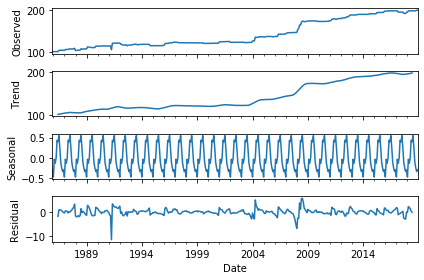

In [7]:
result = seasonal_decompose(df['CatFood']);
result.plot();

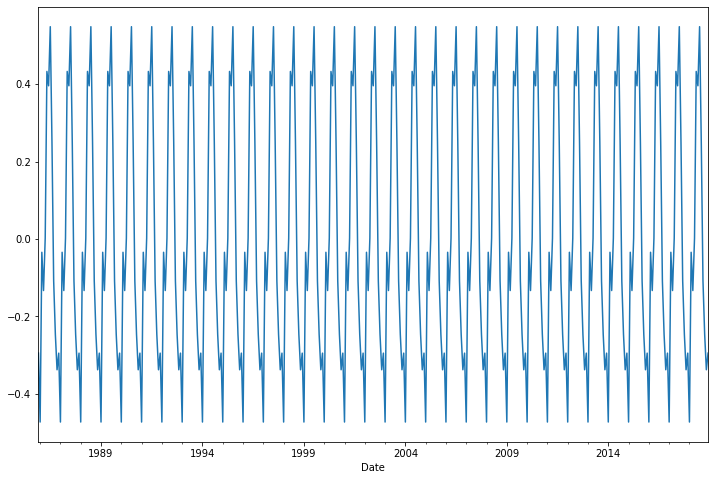

In [11]:
result.seasonal.plot(figsize=[12,8])

In [12]:
from statsmodels.graphics.tsaplots import acf,pacf,plot_acf,plot_pacf 

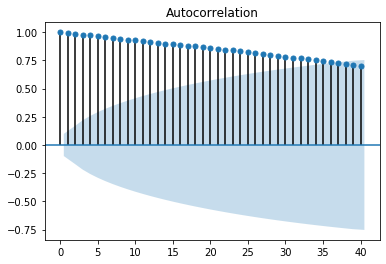

In [14]:
plot_acf(df['CatFood'],lags=40);
plt.show()

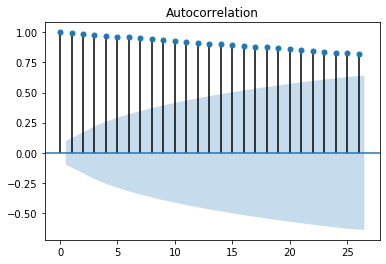

In [17]:
plot_acf(df);
plt.show()

no sharp cut-off after first value so AR component exists

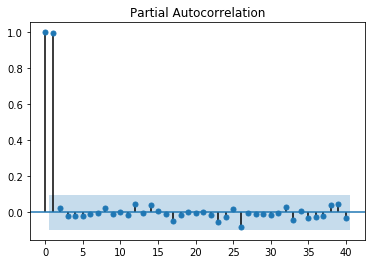

In [11]:
plot_pacf(df['CatFood'],lags=40);

 PACF Plot can reveal recommended AR(p) orders, and an ACF Plot can do the same for MA(q) orders.

This tells us that the AR component should be more important than MA. From the <a href='https://people.duke.edu/~rnau/411arim3.htm'>Duke University Statistical Forecasting site</a>:<br>
> <em>If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we    say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more    easily by adding AR terms than by adding MA terms.</em><br>

Let's take a look at <tt>pmdarima.auto_arima</tt> done stepwise to see if having $p$ and $q$ terms the same still makes sense:

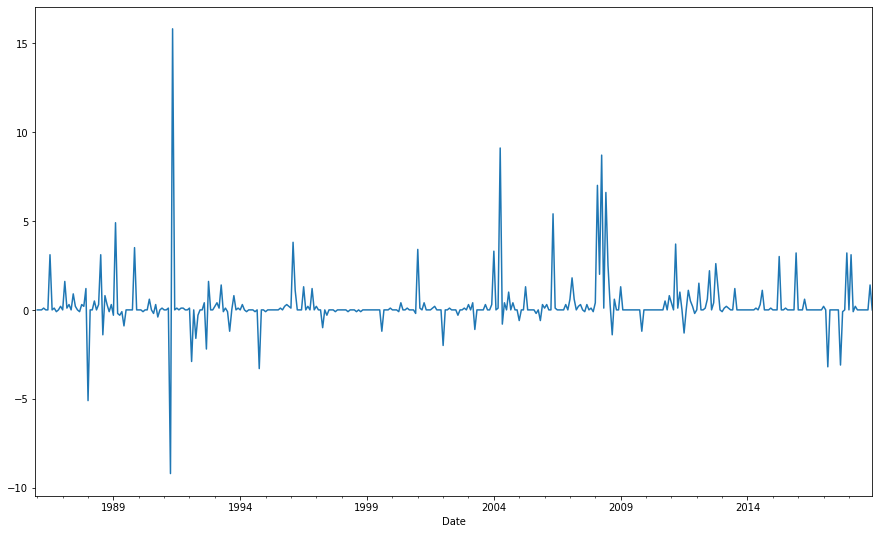

In [22]:
from statsmodels.tsa.statespace.tools import diff

df['d1'] = diff(df['CatFood'],k_diff=1)
df['d1'].plot(figsize=(15,9));

In [18]:
adf_test(df['d1'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.010515e+01
p-value                 1.034639e-17
# lags used             2.000000e+00
# observations          3.930000e+02
critical value (1%)    -3.447099e+00
critical value (5%)    -2.868923e+00
critical value (10%)   -2.570703e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


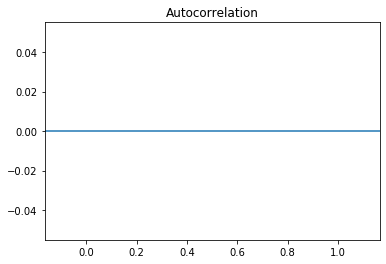

In [24]:
plot_acf(df['d1'],lags=40);

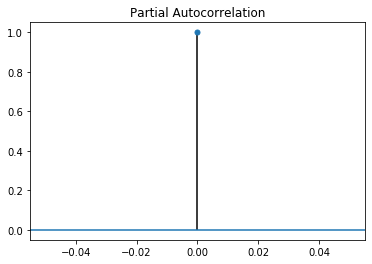

In [20]:
plot_pacf(df['d1'],lags=40);

In [25]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [26]:
adf_test(df['CatFood'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.276662
p-value                   0.976248
# lags used               3.000000
# observations          393.000000
critical value (1%)      -3.447099
critical value (5%)      -2.868923
critical value (10%)     -2.570703
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


To determine whether a series is stationary we can use the augmented Dickey-Fuller Test. In this test the null hypothesis states that  𝜙=1  (this is also called a unit test). The test returns several statistics we'll see in a moment. Our focus is on the p-value. A small p-value ( 𝑝<0.05 ) indicates strong evidence against the null hypothesis

In [27]:
from pmdarima import auto_arima

In [28]:
auto_arima(df['CatFood'],m=12,seasonal =False ,stepwise=True, trace=True).summary()

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 0); AIC=1438.042, BIC=1461.931, Fit time=1.685 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=1448.041, BIC=1456.003, Fit time=0.048 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=1441.760, BIC=1453.704, Fit time=0.088 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=1443.564, BIC=1455.508, Fit time=0.065 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=1457.176, BIC=1461.158, Fit time=0.051 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 0); AIC=1436.058, BIC=1455.965, Fit time=0.137 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 0); AIC=1436.520, BIC=1452.446, Fit time=0.093 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=1440.779, BIC=1456.705, Fit time=0.149 seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 0, 0, 0); AIC=1438.050, BIC=1461.938, Fit time=0.289 seconds
Fit ARIMA: order=(0, 1, 3) seasonal_o

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  397
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -713.029
Date:                Wed, 19 Feb 2020   AIC                           1436.058
Time:                        16:40:11   BIC                           1455.965
Sample:                             0   HQIC                          1443.945
                                - 397                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1379      0.079      1.755      0.079      -0.016       0.292
ar.L1          0.4556      0.230      1.977      0.048       0.004       0.907
ma.L1         -0.5972      0.231     -2.585      0.010      -1.050      -0.144
ma.L2          0.2101      0.035      6.032      0.000       0.142       0.278
sigma2         2.1448      0.058     37.005      0.000       2.031       2.258
===================================================================================
Ljung-Box (Q):                       19.22   Jarque-Bera (JB):             18153.84
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                             3.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        35.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

In [30]:
len(df)

397

In [31]:
train = df.iloc[:385]
test = df.iloc[385:]

In [32]:
model = SARIMAX(train['CatFood'],order=(1,1,2))

In [33]:
result = model.fit()

In [34]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                CatFood   No. Observations:                  385
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -699.042
Date:                Wed, 19 Feb 2020   AIC                           1406.084
Time:                        16:40:12   BIC                           1421.887
Sample:                    12-01-1985   HQIC                          1412.352
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6452      0.180      3.585      0.000       0.292       0.998
ma.L1         -0.7690      0.179     -4.287      0.000      -1.121      -0.417
ma.L2          0.2273      0.031      7.253      0.000       0.166       0.289
sigma2         2.2315      0.058     38.225      0.000       2.117       2.346
===================================================================================
Ljung-Box (Q):                       19.31   Jarque-Bera (JB):             18100.78
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             3.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
start = len(train)
end = len(train) + len(test)-1

In [36]:
prediction = result.predict(start,end,typ = 'levels').rename('ARIMA order')

prediction

2018-01-01    194.976601
2018-02-01    195.395060
2018-03-01    195.665065
2018-04-01    195.839283
2018-05-01    195.951694
2018-06-01    196.024226
2018-07-01    196.071026
2018-08-01    196.101223
2018-09-01    196.120707
2018-10-01    196.133279
2018-11-01    196.141391
2018-12-01    196.146625
Freq: MS, Name: ARIMA order, dtype: float64

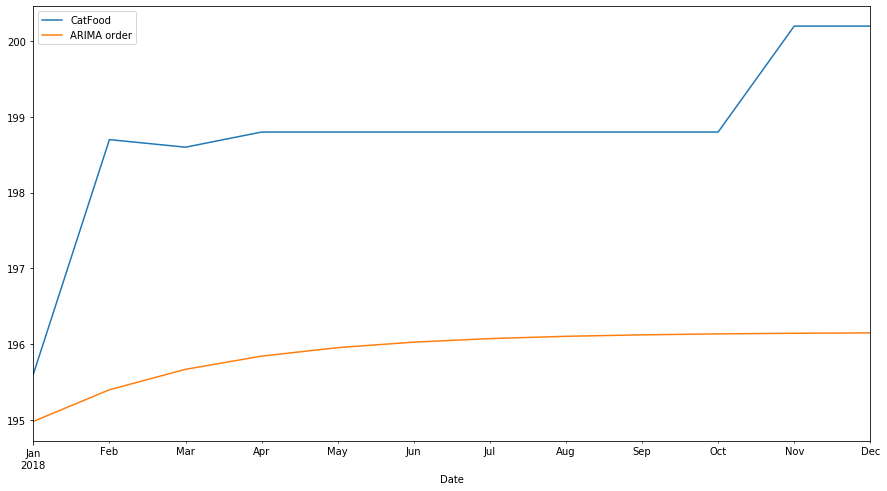

In [37]:
test['CatFood'].plot(legend =True,figsize= (15,8))
prediction.plot(legend = True)

In [38]:
from statsmodels.tools.eval_measures import rmse,mse

In [39]:
error = rmse(test['CatFood'],prediction)

In [40]:
error

2.978136717234003

In [41]:
test['CatFood'].mean()

198.74166666666665

In [42]:
prediction.mean()

195.88051492287073

Future Dataset

In [43]:
model = SARIMAX(df['CatFood'],order=(1,1,2))

In [44]:
results = model.fit()

In [45]:
fcast = results.predict(len(df),len(df)+24).rename('SARIMA forecast')

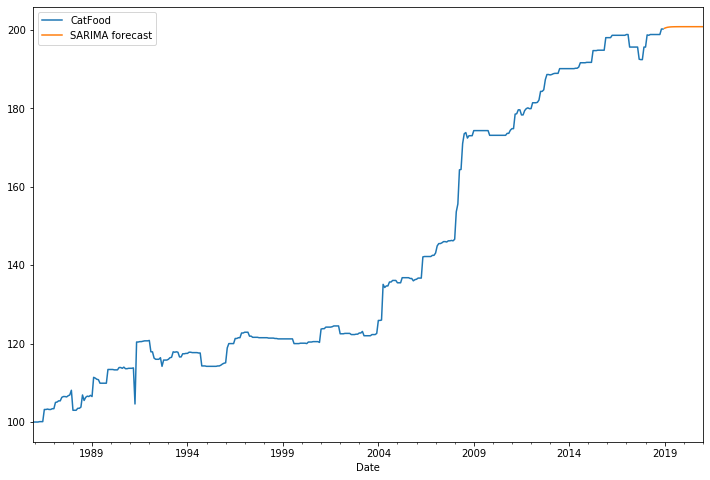

In [46]:
df['CatFood'].plot(legend=True,figsize=[12,8])

fcast.plot(legend =True)

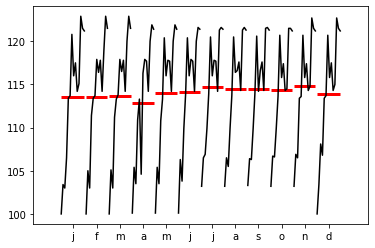

In [47]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot

# Note: add a semicolon to prevent two plots being displayed in jupyter
month_plot(df['CatFood'][:'1999-01-01']);

In [48]:
df['CatFood'][:'1999-01-01'].tail(50)

Date
1994-12-01    114.3
1995-01-01    114.2
1995-02-01    114.2
1995-03-01    114.2
1995-04-01    114.2
1995-05-01    114.2
1995-06-01    114.2
1995-07-01    114.2
1995-08-01    114.3
1995-09-01    114.3
1995-10-01    114.5
1995-11-01    114.8
1995-12-01    115.0
1996-01-01    115.1
1996-02-01    118.9
1996-03-01    120.0
1996-04-01    120.0
1996-05-01    120.0
1996-06-01    120.0
1996-07-01    121.3
1996-08-01    121.3
1996-09-01    121.5
1996-10-01    121.5
1996-11-01    122.7
1996-12-01    122.7
1997-01-01    122.9
1997-02-01    122.9
1997-03-01    122.9
1997-04-01    121.9
1997-05-01    121.9
1997-06-01    121.6
1997-07-01    121.6
1997-08-01    121.6
1997-09-01    121.6
1997-10-01    121.5
1997-11-01    121.5
1997-12-01    121.5
1998-01-01    121.5
1998-02-01    121.5
1998-03-01    121.5
1998-04-01    121.4
1998-05-01    121.4
1998-06-01    121.4
1998-07-01    121.4
1998-08-01    121.3
1998-09-01    121.3
1998-10-01    121.2
1998-11-01    121.2
1998-12-01    121.2
1999-01-01    1